# <center> Predicting Zebrafish Movements in Virtual Reality

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display
import functions
from tqdm import tqdm
from matplotlib import animation
from IPython.display import Image

## Context

This project is part of a collaboration between EPFL and UNIL.
It aims to understand the perceptual and computational rules underlying social interactions in zebrafish through behavioral and neural data analysis.

In this experiment, a single zebrafish swims in a controlled environment equipped with a virtual reality system.  
One or several visual stimuli (dots) are projected on a screen, simulating the motion patterns of another fish, typically a sequence of “bursts and glides” characteristic of zebrafish swimming behavior.  
The fish’s trajectory, orientation, and velocity are continuously tracked, as well as the trajectories and properties of the stimuli.

## Objective

The goal of this notebook is to use the preprocessed dataset (prepared in AllFish_GsizeMotionSingle notebook) to model and predict the future position of the fish** based on its past movements and the motion of the stimuli.  
This predictive approach will serve as a first computational prototype for understanding how fish integrate visual information and self-motion to generate coordinated behavior.

## Data description 

The dataset contains synchronized time series including:
- Fish positions (`f0_x`, `f0_y`) and orientations (`f0_ori`)
- Stimulus positions and attributes (`d0_x`, `d0_y`, `d0_stim`)
- Condition : Description of experiment

Each row corresponds to a time step in the experiment, allowing us to build temporal sequences that capture short-term dynamics of perception and movement.

## <center> Exploring dataset and preprocessing

In [23]:
df = pd.read_csv('preprocessed_data.csv')

df.head(-10)

,f0_x,f0_y,f0_ori,f1_x,f1_y,f1_ori,f2_x,f2_y,f2_ori,f3_x,...,d5_x,d5_y,d5_stim,d6_x,d6_y,d6_stim,d7_x,d7_y,d7_stim,condition
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323985,221.0,179.0,6.144,108.0,183.0,1.242,232.0,154.0,6.057,207.0,...,180,180,none,180,180,none,180,180,none,bout
323986,220.0,179.0,6.170,108.0,183.0,1.240,232.0,154.0,6.064,207.0,...,180,180,none,180,180,none,180,180,none,bout
323987,221.0,179.0,6.141,108.0,183.0,1.225,233.0,154.0,6.081,207.0,...,180,180,none,180,180,none,180,180,none,bout
323988,221.0,179.0,6.137,108.0,183.0,1.220,232.0,154.0,6.075,207.0,...,180,180,none,180,180,none,180,180,none,bout


Quick stimulus description :

> The max distance between fish and stimulus is approximately 378 mm.

> When there is no stimulus k, dk_stim = 'none' and dk_x = dk_y = 180.


In [24]:
df.dtypes.value_counts()

float64    45
int64      16
object      9
Name: count, dtype: int64

In [25]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols.tolist()

['d0_stim',
 'd1_stim',
 'd2_stim',
 'd3_stim',
 'd4_stim',
 'd5_stim',
 'd6_stim',
 'd7_stim',
 'condition']

In [26]:
unique_conditions = df['condition'].unique()
print(f"There are {len(unique_conditions)} unique conditions:\n")
for c in unique_conditions:
    print("-", c)

There are 18 unique conditions:

- inter_stim_pause
- CLsemi1800_g4-0_s3.5-3.5
- CLsemi1800_g0-2_s3.5-3.5
- CLsemi1800_g0-4_s3.5-3.5
- CLsemi1800_g8-0_s3.5-3.5
- CLsemi1800_g0-4_s0-0
- CLsemi1800_g8-0_s0-0
- CLsemi1800_g6-0_s3.5-3.5
- CLsemi1800_g0-8_s0-0
- CLsemi1800_g1-0_s3.5-3.5
- CLsemi1800_g0-1_s3.5-3.5
- CLsemi1800_g2-0_s3.5-3.5
- CLsemi1800_g0-8_s3.5-3.5
- CLsemi1800_g0-6_s3.5-3.5
- CLsemi1800_g4-0_s0-0
- CLsemi1800_g0-1_s0-0
- CLsemi1800_g1-0_s0-0
- bout


In [27]:
def check_unique_values(df):
    """Display numbre of possible values for each features with object type."""
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")
        if unique_vals <= 10:
            print(" →", df[col].unique())
        print("-" * 40)
        
check_unique_values(df)

d0_stim: 18 unique values
----------------------------------------
d1_stim: 13 unique values
----------------------------------------
d2_stim: 11 unique values
----------------------------------------
d3_stim: 11 unique values
----------------------------------------
d4_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d5_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d6_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g0-8_s0-0' 'CLsemi1800_g0-8_s3.5-3.5']
----------------------------------------
d7_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'

##### There is a non sens to give conditional experiment information to the model. We want to give the present and past full state position of the fish and its visual field.

In [28]:
df = df.drop(columns=['condition'])

# transform dk_stim for each stimulus k into 0 if the feature is 'none' else 1
for k in range(8):
    df[f'd{k}_stim'] = df[f'd{k}_stim'].apply(lambda x: 0 if x == 'none' else 1)

In [29]:
df, _ = functions.remove_nan_plus_constant_and_correlated_features(df, corr_threshold=1.0)

The dataset contains : 0.2623456790123457% of NaN.
There are few NaN, therefore we make the choice to remove them.
✅ No constant features found.
✅ No highly correlated features found.


In the actual dataset, each fish has its own set of columns (f0_x, f1_x, etc.).
However, since our goal is to predict the next position of a single fish, and because each fish behaves independently of the others in this experimental setup, it doesn’t make sense to include information from other fish as model inputs.

We therefore restructure the data so that each row corresponds to one fish at one time frame, with shared context variables (stimuli, condition, etc.) still available.
This makes the data more consistent with our modeling goal, learning the movement dynamics of individual fish, not group interactions.

In [30]:
fish_cols = [c for c in df.columns if c.startswith('f') and any(x in c for x in ['_x', '_y', '_ori'])]
df = functions.reshape_repeated_columns(df)
df = df.drop(columns=['fish_id']) # Make no sens to keep fish_id for prediction
df = df.drop(columns=['frame']) # Make no sens to keep frame for prediction
df.head()

✅ Reshape complete: 324000 frames × 15 fish → 4860000 rows
Columns: ['f_x', 'f_y', 'f_ori', 'd0_x', 'd0_y', 'd0_stim', 'd1_x', 'd1_y', 'd1_stim', 'd2_x'] ...


,f_x,f_y,f_ori,d0_x,d0_y,d0_stim,d1_x,d1_y,d1_stim,d2_x,...,d4_stim,d5_x,d5_y,d5_stim,d6_x,d6_y,d6_stim,d7_x,d7_y,d7_stim
0,NaN,NaN,NaN,180,180,0,180,180,0,180,...,0,180,180,0,180,180,0,180,180,0
1,NaN,NaN,NaN,180,180,0,180,180,0,180,...,0,180,180,0,180,180,0,180,180,0
2,NaN,NaN,NaN,180,180,0,180,180,0,180,...,0,180,180,0,180,180,0,180,180,0
3,NaN,NaN,NaN,180,180,0,180,180,0,180,...,0,180,180,0,180,180,0,180,180,0
4,NaN,NaN,NaN,180,180,0,180,180,0,180,...,0,180,180,0,180,180,0,180,180,0


In [31]:
df = functions.compute_d_orientation(df)
df = functions.compute_speed(df)

df.head()

,f_speed,d_ori,f_x,f_y,f_ori,d0_x,d0_y,d0_stim,d1_x,d1_y,...,d4_stim,d5_x,d5_y,d5_stim,d6_x,d6_y,d6_stim,d7_x,d7_y,d7_stim
0,NaN,NaN,NaN,NaN,NaN,180,180,0,180,180,...,0,180,180,0,180,180,0,180,180,0
1,NaN,NaN,NaN,NaN,NaN,180,180,0,180,180,...,0,180,180,0,180,180,0,180,180,0
2,NaN,NaN,NaN,NaN,NaN,180,180,0,180,180,...,0,180,180,0,180,180,0,180,180,0
3,NaN,NaN,NaN,NaN,NaN,180,180,0,180,180,...,0,180,180,0,180,180,0,180,180,0
4,NaN,NaN,NaN,NaN,NaN,180,180,0,180,180,...,0,180,180,0,180,180,0,180,180,0


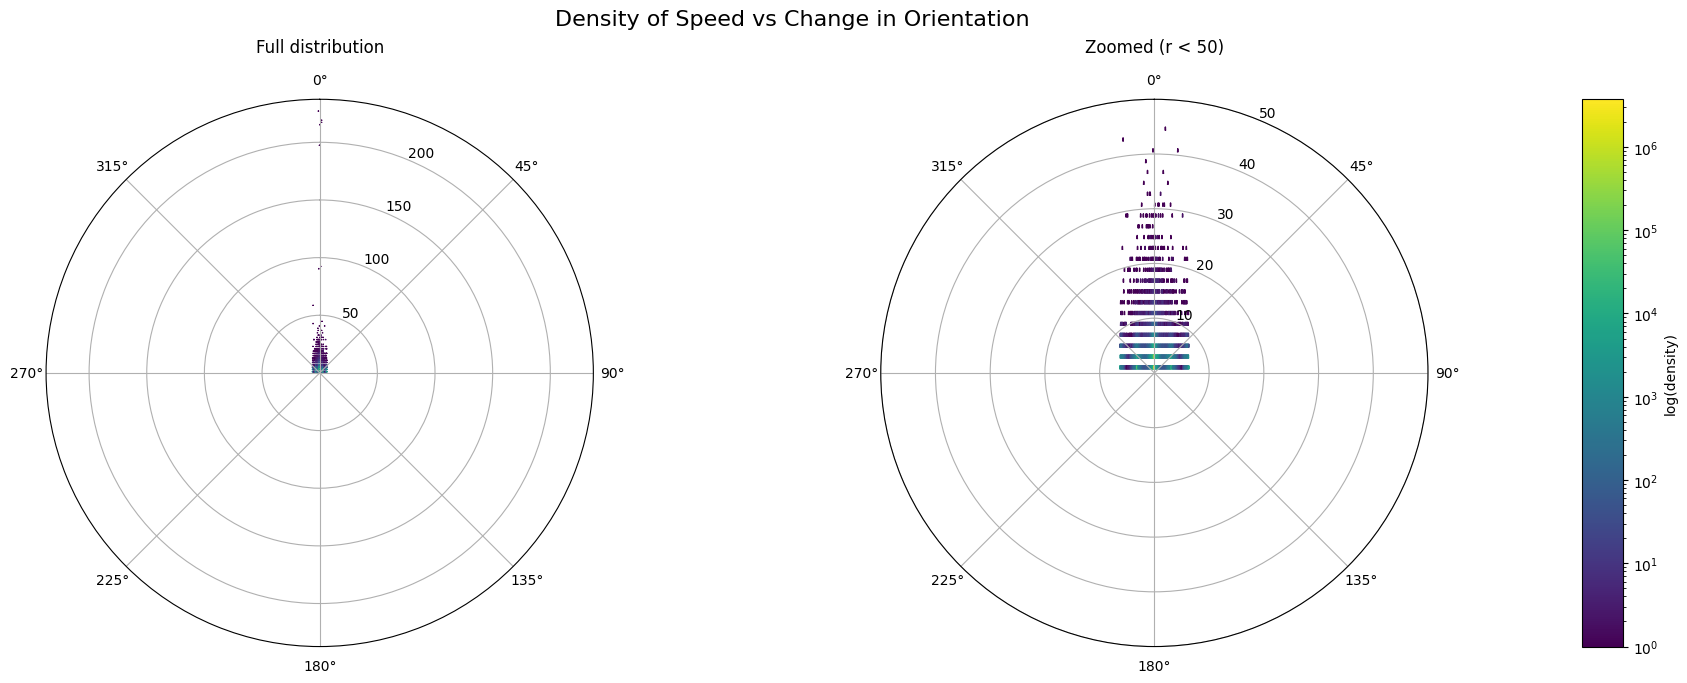

In [32]:
# Convert to polar coordinates (r = speed, θ = change in orientation)
r = df["f_speed"]
theta = df["d_ori"]

# --- Create figure layout ---
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])  # full plot | zoomed plot | colorbar

# Shared normalization (so both plots use same color range)
vmin, vmax = 1, 1000
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# --- 📊 (1) Full plot (identical to your original one) ---
ax1 = fig.add_subplot(gs[0, 0], polar=True)
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
hb1 = ax1.hexbin(theta, r, gridsize=100, cmap="viridis", bins='log')
ax1.set_title("Full distribution", pad=15)

# --- 🔍 (2) Zoomed plot ---
ax2 = fig.add_subplot(gs[0, 1], polar=True)
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
hb2 = ax2.hexbin(theta, r, gridsize=100, cmap="viridis", bins='log')
ax2.set_rmax(50)  # zoom on low speeds
ax2.set_title("Zoomed (r < 50)", pad=15)

# --- 🎨 (3) Separate colorbar ---
cax = fig.add_subplot(gs[0, 2])
cb = fig.colorbar(hb1, cax=cax)
cb.set_label("log(density)")

plt.suptitle("Density of Speed vs Change in Orientation", fontsize=16, y=0.97)
plt.tight_layout()
plt.show()

### Interpreting the Polar Density Plot

This plot shows the **distribution of fish movements** in **polar coordinates**, where:

- **r (radius)** = the *speed* of the fish (the magnitude of its displacement between frames).  
- **θ (angle)** = the *change in orientation* (Δorientation, in radians) between consecutive frames.

Each hexagonal bin represents how frequently a given combination of speed and turning angle occurs:
- Points near **θ = 0** correspond to **straight motion** (no turning).  
- Points near **|θ| = π/2** or **π** correspond to **sharp turns or reversals**.  
- The **color intensity** encodes how often those motions occur (darker = more frequent).

As the points near θ = 0, we will simply use orientation in radian rather making more trigonometric computations.

_

Since the dataset represents **time series** rather than independent samples, each observation depends on the fish’s recent past.  
To make the model aware of temporal dependencies, we include **lag features** the positions and orientations from the last few frames.

Formally, we build the following features:

$$
\text{Input: } \{f_x(t - 1), \ldots, f_x(t - 60), \; f_y(t - 1), \ldots, f_y(t - 60), \; f_{\text{ori}}(t - 1), \ldots, f_{\text{ori}}(t - 60)\}
$$

$$
\text{Target: } \{ f_x(t + 3), \; f_y(t + 3), \; f_{\text{ori}}(t +3) \}
$$

This way, the model learns motion dynamics, how past positions and orientations lead to the next movement — instead of treating each frame as an isolated event.

In [33]:
# Parameters
n_lags = 60          # ~1.5s at 30 FPS
subsample = 3        
cols_to_lag = ['f_speed', 'd_ori']

# Create lag features with subsampling
for col in cols_to_lag:
    for lag in range(subsample, n_lags + 1, subsample):
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

print(f"✅ Created lag features for {cols_to_lag} with subsampling every {subsample} frames "
      f"(covering {n_lags / 30:.2f} seconds at 30 FPS).")

✅ Created lag features for ['f_speed', 'd_ori'] with subsampling every 3 frames (covering 2.00 seconds at 30 FPS).


##### The dataset was recorded at 30 frames per second, meaning that 15 frames correspond to roughly 0.5 seconds.
##### Based on the experiment description, fish approximately make a new movement decision about once per second (each “bout”).
##### Setting delta_t = 15 therefore allows us to predict a fish’s state halfway between two typical bouts, far enough to capture meaningful motion, but close enough to remain within a single behavioral context.

In [34]:
delta_t = 15

# Target = 15 frames ahead
df['f_speed_next'] = df['f_speed'].shift(-delta_t)
df['d_ori_next'] = df['d_ori'].shift(-delta_t)

# Drop NaN rows created by shifting
df = df.dropna(subset=[f'f_speed_lag_{n_lags}', 'f_speed_next'])

df.head()

,f_speed,d_ori,f_x,f_y,f_ori,d0_x,d0_y,d0_stim,d1_x,d1_y,...,d_ori_lag_39,d_ori_lag_42,d_ori_lag_45,d_ori_lag_48,d_ori_lag_51,d_ori_lag_54,d_ori_lag_57,d_ori_lag_60,f_speed_next,d_ori_next
206,0.0,0.060,120.0,192.0,4.276,180,180,0,180,180,...,0.009,-0.061,0.119,-0.010,-0.027,-0.025,0.083,0.363,0.0,0.015
207,0.0,-0.002,120.0,192.0,4.274,180,180,0,180,180,...,0.006,0.051,0.020,0.010,-0.064,0.028,0.105,-0.005,0.0,-0.049
208,1.0,-0.016,120.0,191.0,4.258,180,180,0,180,180,...,-0.004,-0.009,0.013,-0.119,0.086,0.073,-0.091,-0.017,0.0,0.027
209,0.0,0.010,120.0,191.0,4.268,180,180,0,180,180,...,-0.045,0.009,-0.061,0.119,-0.010,-0.027,-0.025,0.083,0.0,0.009
210,0.0,-0.001,120.0,191.0,4.267,180,180,0,180,180,...,0.057,0.006,0.051,0.020,0.010,-0.064,0.028,0.105,0.0,-0.021


In [35]:
x_cols = [f"d{i}_x" for i in range(8)]
y_cols = [f"d{i}_y" for i in range(8)]

orientation_radius_df = functions.compute_orientations_and_radii(df, x_cols, y_cols)

# Fusion avec ton DataFrame d’origine :
df = pd.concat([df, orientation_radius_df], axis=1)

df = df.drop(columns=x_cols + y_cols)

In [36]:
df.head()

,f_speed,d_ori,f_x,f_y,f_ori,d0_stim,d1_stim,d2_stim,d3_stim,d4_stim,...,d3_ori,d3_r,d4_ori,d4_r,d5_ori,d5_r,d6_ori,d6_r,d7_ori,d7_r
206,0.0,0.060,120.0,192.0,4.276,0,0,0,0,0,...,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441
207,0.0,-0.002,120.0,192.0,4.274,0,0,0,0,0,...,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441
208,1.0,-0.016,120.0,191.0,4.258,0,0,0,0,0,...,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441
209,0.0,0.010,120.0,191.0,4.268,0,0,0,0,0,...,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441
210,0.0,-0.001,120.0,191.0,4.267,0,0,0,0,0,...,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441,0.785398,254.558441


In [37]:
df=df.drop(columns=['f_x', 'f_y','f_ori'])

## <center> Creates train - val - test set

##### Our goal is to predict the fish’s next position and orientation $x_{t+1}$, $y_{t+1}$, and $\text{ori}_{t+1}$ using only the information available at the current time $t$.  
##### Formally, this means estimating the conditional expectations:

$$
\begin{aligned}
\hat{x}_{t+1} &= \mathbb{E}[x_{t+1} \mid \mathcal{F}_t] \\
\hat{y}_{t+1} &= \mathbb{E}[y_{t+1} \mid \mathcal{F}_t] \\
\hat{\text{ori}}_{t+1} &= \mathbb{E}[\text{ori}_{t+1} \mid \mathcal{F}_t]
\end{aligned}
$$

##### where $\mathcal{F}_t$ represents all information known at time $t$ (fish position, stimuli, condition, etc.).  
##### In other words, the model learns the most likely future state of the fish given the current context.

In [38]:
target_cols = ["f_speed_next", "d_ori_next"]

X_train, X_val, X_test, target_speed_train, target_speed_val, target_speed_test, target_ori_train, target_ori_val, target_ori_test = functions.temporal_train_val_test_split(df, target_cols)

✅ Temporal split complete:
  Train: 3399106 rows (70.0%)
  Val:   728380 rows (15.0%)
  Test:  728380 rows (15.0%)


## <center> Train XGBoost

In [39]:
cat_cols = X_train.select_dtypes(include=['object']).columns
cat_cols.tolist()

[]

In [40]:
# --- Train model for speed prediction ---
model_speed = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_speed.fit(X_train, target_speed_train, eval_set=[(X_val, target_speed_val)], verbose=False)


# --- Train model for Orientation prediction ---
model_ori = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_ori.fit(X_train, target_ori_train, eval_set=[(X_val, target_ori_val)], verbose=False)

# --- Predictions ---
pred_speed = model_speed.predict(X_test)
pred_ori = model_ori.predict(X_test)

# --- RMSE (Root Mean Squared Error) ---
rmse_speed = mean_squared_error(target_speed_test, pred_speed, squared=False)
rmse_ori = mean_squared_error(target_ori_test, pred_ori, squared=False)


# --- Display results ---
print("📊 Model Performance Summary:")
print(f"RMSE Speed: {rmse_speed:.4f}")
print(f"RMSE Orientation: {rmse_ori:.4f}")

📊 Model Performance Summary:
RMSE Speed: 0.8469
RMSE Orientation: 0.5753


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
rmse_speed_norm = rmse_speed / (df['f_speed'].max() - df['f_speed'].min())
rmse_ori_norm = rmse_ori / (df['d_ori'].max() - df['d_ori'].min())

In [42]:
from sklearn.metrics import mean_squared_error
import pandas as pd

# --- Static baseline ---
# Hypothesis: fish does not move (same position and orientation)
baseline_pred_speed = df.loc[X_test.index, 'f_speed']
baseline_pred_ori = df.loc[X_test.index, 'd_ori']

baseline_rmse_speed = mean_squared_error(target_speed_test, baseline_pred_speed, squared=False) / (df['f_speed'].max() - df['f_speed'].min())
baseline_rmse_ori = mean_squared_error(target_ori_test, baseline_pred_ori, squared=False) / (df['d_ori'].max() - df['d_ori'].min())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
# Build summary table
results_df = pd.DataFrame({
    "Metric": ["Speed", "Change in Orientation (rad)"],
    "Model RMSE": [rmse_speed_norm, rmse_ori_norm],
    "Static Baseline RMSE": [baseline_rmse_speed, baseline_rmse_ori],
})

# Format for readability
results_df = results_df.round(4)

# Display nicely
print("📊 Model Performance Summary:\n")
display(
    results_df.style.set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .set_caption("Comparison of Model and Baselines (normalized RMSE)")
)

📊 Model Performance Summary:



,Metric,Model RMSE,Static Baseline RMSE
0,Speed,0.003700,0.005300
1,Change in Orientation (rad),0.045800,0.064800
